In [3]:
# interpolate
# regress
# sample

import numpy
import warnings

In [ ]:
class BarycentricRationalApproximant:

    def __init__(self, zj, fj, wj):
        self.zj = numpy.asarray(zj)
        self.fj = numpy.asarray(fj)
        self.wj = numpy.asarray(wj)
        assert self.zj.ndim == self.fj.ndim == self.wj.ndim == 1
        assert self.zj.size == self.fj.size == self.wj.size
        self.M = len(zj)

    def __call__(self, z):
        zj = self.zj
        fj = self.fj
        wj = self.wj
        Cd = z[:, None] - zj[None, :]
        ij, jj = numpy.nonzero(Cd == 0)
        Cd[ij, jj] = 1
        C = 1/Cd
        f = C.dot(wj*fj)/C.dot(wj)
        f[ij] = fj[jj]
        return f

    def __len__(self):
        return self.M

    @functools.cached_property
    def poles(self):
        zj = self.zj
        wj = self.wj
        B = numpy.eye(len(wj) + 1)
        B[0, 0] = 0
        E = numpy.block([
            [0, wj],
            [numpy.ones((self.M, 1)), numpy.diag(zj)]
        ])
        p = scipy.linalg.eigvals(E, B)
        return numpy.real_if_close(p[numpy.isfinite(p)])

    @functools.cached_property
    def residues(self):
        poles = self.poles
        # compute residues via formula for simple poles using L'Hôpital's rule
        # to evaluate the limit
        ## cf: https://en.wikipedia.org/wiki/Residue_(complex_analysis)#Simple_poles
        zj = self.zj
        fj = self.fj
        wj = self.wj
        C = 1/(poles[:, None] - zj[None, :])
        n = C.dot(fj*wj)
        d = (-C**2).dot(wj)
        residues = n/d
        return residues

    def polres(self):
        return self.poles, self.residues

    @classmethod
    def aaa(cls, z, f, tol=1e-13, M=None, Mmax=200):
        inf = numpy.inf
        z = numpy.asarray(z)
        f = numpy.asarray(f)
        assert z.ndim == f.ndim == 1
        assert z.size == f.size
        N = len(z)
        j = []
        e = []
        hist = []
        k = list(range(N))
        fm = f.mean()*numpy.ones(N)
        r = f - fm
        e.append(numpy.linalg.norm(r, inf))
        rtol = tol*numpy.linalg.norm(f, inf)
        hist.append({
            'j': j.copy(),
            'k': k.copy(),
            'e': e.copy(),
            'f': fm.copy(),
            'r': r.copy(),
        })
        if M is not None:
            Mmax = M
        for m in range(Mmax):
            jm = numpy.argmax(abs(r))
            j.append(jm)
            k.remove(jm)
            C = 1/(z[k, None] - z[None, j])
            A = (f[k, None] - f[None, j])*C
            _, _, Vh = numpy.linalg.svd(A)
            wj = Vh[-1, :].conj()
            wj = wj
            n = C.dot(wj*f[j])
            d = C.dot(wj)
            fm = f.copy()
            fm[k] = n/d
            r = f - fm
            e.append(numpy.linalg.norm(r, inf))
            hist.append({
                'j': j.copy(),
                'k': k.copy(),
                'e': e.copy(),
                'f': fm.copy(),
                'r': r.copy(),
            })
            if M is None and e[-1] < rtol:
                break
        else:
            if M is None:
                warnings.warn('Maximum number of iterations reached.')
        jnz = wj != 0
        wj = wj[jnz]
        j = numpy.asarray(j)
        zj = z[j[jnz]]
        fj = f[j[jnz]]
        b = cls(zj, fj, wj)
        b.j = j
        b.k = asarray(k)
        b.fit_history = hist
        return b

aaa.interp
aaa.lstsq
aaa.sample

In [56]:
import numpy
import scipy

N = 23
#m = 100
#M = m*int(1.5*N)
M = 21

a = numpy.random.rand(M, N)
#%time s = numpy.linalg.svd(a)
s = numpy.linalg.svd(a)
n = scipy.linalg.null_space(a)
s.Vh.shape, n.shape

((23, 23), (23, 2))

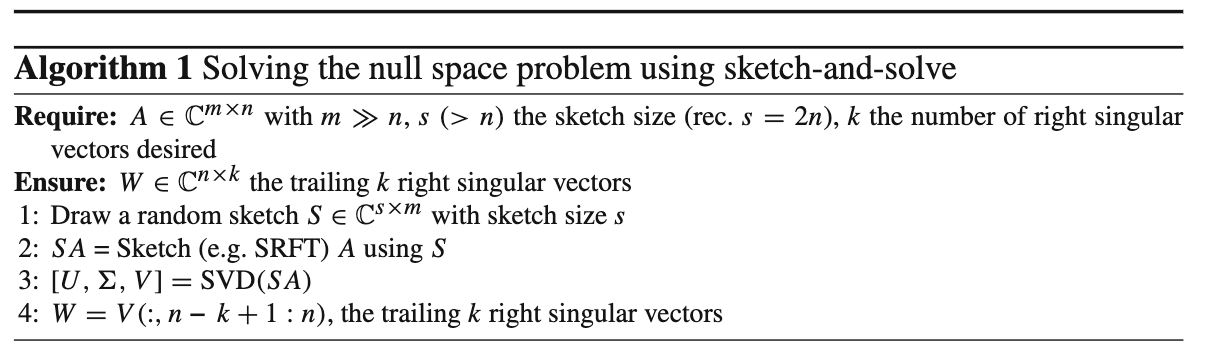

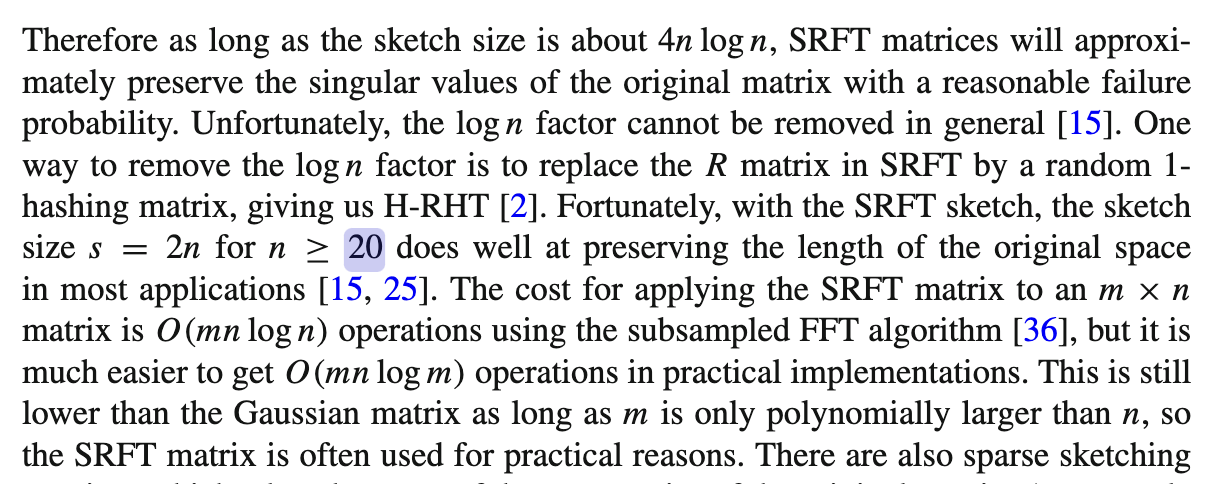

```python
# Loewner matrix
L.shape == M, N

M == Nfreq * Nloc
N == Nmodes * Nloc

If Nmodes = Nfreq, then M == N

If Nmodes = Nfreq - 1, then:

* M == Nfreq * Nloc
* N == (Nfreq - 1) * Nloc = Nfreq * Nloc - Nloc
* nullspace(L) = M - N = Nfreq * Nloc - (Nfreq * Nloc - Nloc) = Nloc
* nullspace(L).shape = N, Nloc
```

In [312]:
X = numpy.reshape([0.1, 0.25, 1], (-1, 1))
y = numpy.reshape([0.1, 0.5, 1], (-1, 1))
A = numpy.hstack((numpy.ones_like(X), X, X**2, X**3, X**4, numpy.log(X)))
c, _, _, _ = scipy.linalg.lstsq(A, y)
n = scipy.linalg.null_space(A)
nullity = n.shape[1]
f = 1
cs = c + n.reshape(-1, nullity).dot(f*((0.5 - numpy.random.rand(nullity, 2000))))
#assert numpy.allclose(A.dot(cs), y)
cs.shape

(6, 2000)

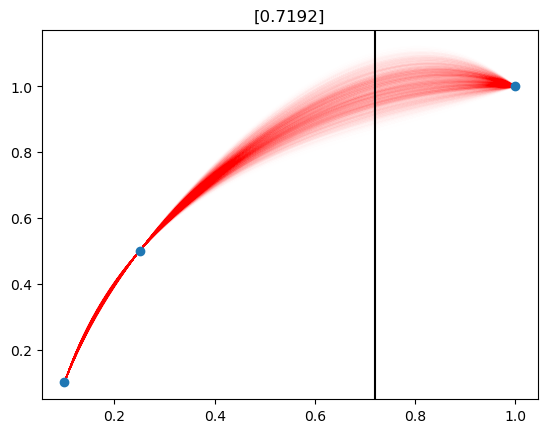

In [313]:
import matplotlib.pyplot as mpl

Xa = numpy.linspace(0.1, 1, 1001).reshape(-1, 1)
Aa = numpy.hstack((numpy.ones_like(Xa), Xa, Xa**2, Xa**3, Xa**4, numpy.log(Xa)))
ya = Aa.dot(cs)

Xu = Xa[numpy.argsort(ya.max(axis=1) - ya.min(axis=1))]

mpl.figure()
mpl.plot(Xa, ya, c='r', alpha=0.005)
mpl.plot(X, y, 'o')
#for i in range(5):
#    xa = Xu[-(i + 1)]
#    mpl.axvline(xa, c='k', alpha=0.1)
mpl.axvline(Xu[-1], c='k')
mpl.title(Xu[-1])
mpl.show()

In [230]:
numpy.argsort?

Signature:       numpy.argsort(a, axis=-1, kind=None, order=None)
Call signature:  numpy.argsort(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function argsort at 0x1073ba8e0>
File:            /opt/anaconda3/envs/aaakit/lib/python3.11/site-packages/numpy/core/fromnumeric.py
Docstring:      
Returns the indices that would sort an array.

Perform an indirect sort along the given axis using the algorithm specified
by the `kind` keyword. It returns an array of indices of the same shape as
`a` that index data along the given axis in sorted order.

Parameters
----------
a : array_like
    Array to sort.
axis : int or None, optional
    Axis along which to sort.  The default is -1 (the last axis). If None,
    the flattened array is used.
kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
    Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
    and 'mergesort' use timsort under the covers and, in general, the
    actual imple

In [205]:
import scipy

In [22]:
M = numpy.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
null = scipy.linalg.null_space(M)

In [25]:
M.dot((1e10*null))

array([[-3.33786011e-06],
       [ 9.53674316e-07],
       [ 5.24520874e-06]])

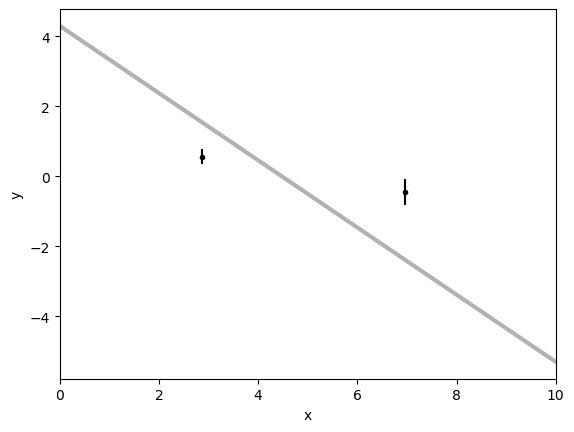

In [34]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 2
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -0.243 ± 0.105
b = 1.247 ± 0.447


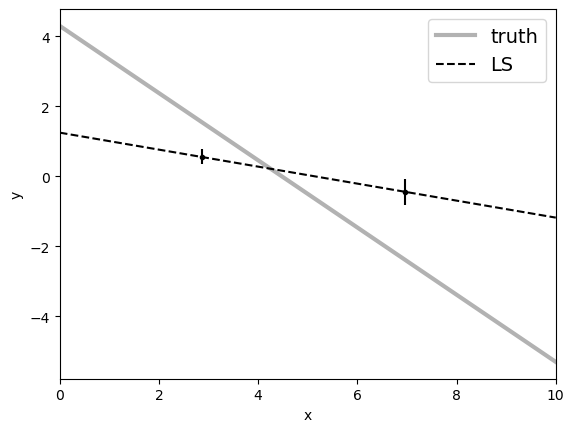

In [35]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [36]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -0.243
b = 1.247
f = 0.000


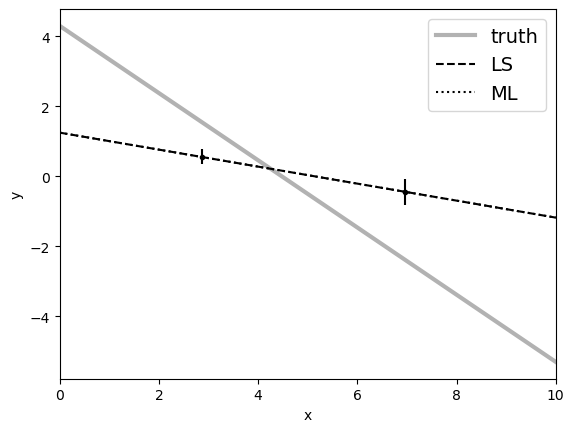

In [37]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [38]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [39]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 50000, progress=True);

You must install the tqdm library to use progress indicators with emcee


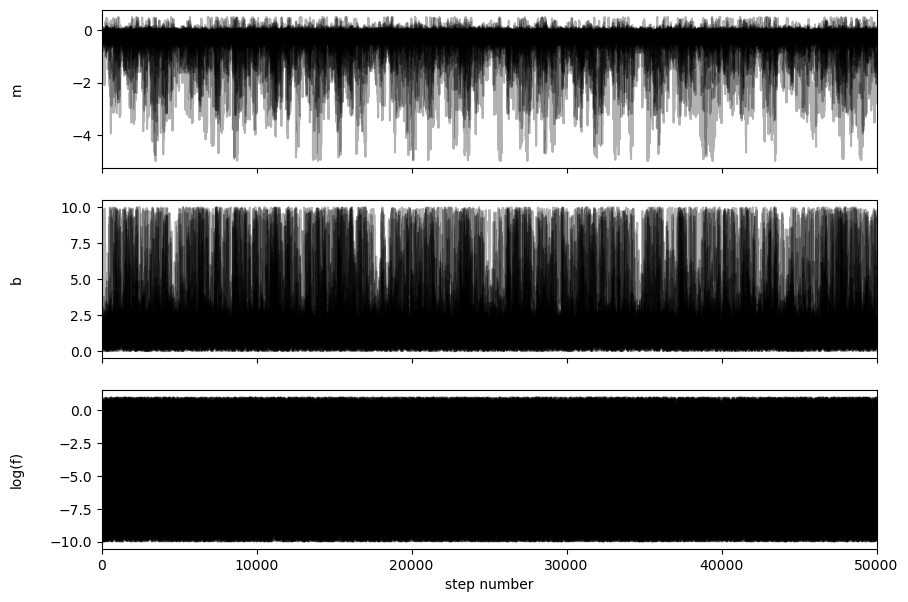

In [40]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [41]:
tau = sampler.get_autocorr_time()
print(tau)

[278.47866605 243.94714386 138.2520602 ]


In [42]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(106432, 3)


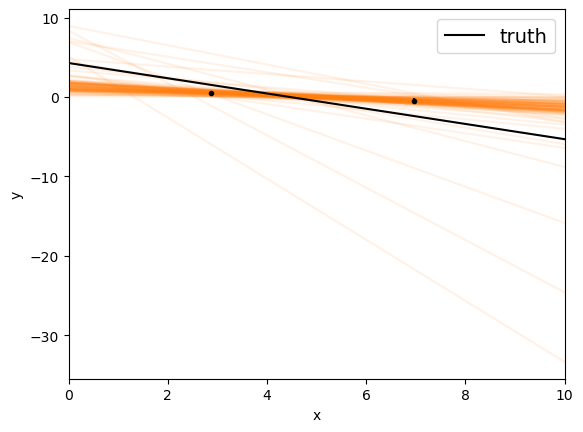

In [43]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

/opt/anaconda3/envs/aaakit/lib/python3.11/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/opt/anaconda3/envs/aaakit/lib/python3.11/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


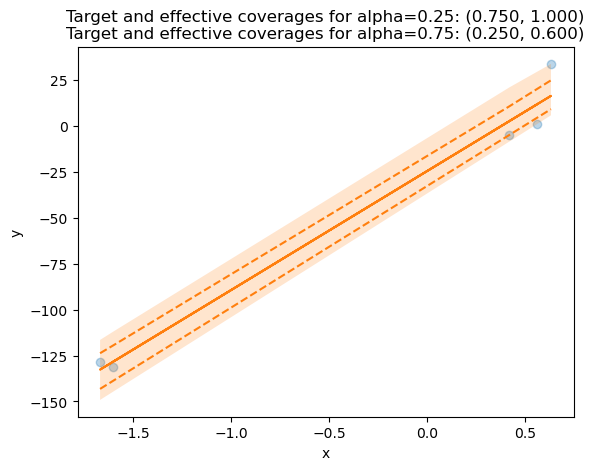

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor

regressor = LinearRegression()
X, y = make_regression(n_samples=5, n_features=1, noise=20, random_state=59)

alpha = [1/4, 1 - 1/4]
mapie = MapieRegressor(regressor, method="plus")
mapie.fit(X, y)
y_pred, y_pis = mapie.predict(X, alpha=alpha)

coverage_scores = [
    regression_coverage_score(y, y_pis[:, 0, i], y_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]

plt.xlabel("x")
plt.ylabel("y")
plt.scatter(X, y, alpha=0.3)
plt.plot(X, y_pred, color="C1")
order = np.argsort(X[:, 0])
plt.plot(X[order], y_pis[order][:, 0, 1], color="C1", ls="--")
plt.plot(X[order], y_pis[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    X[order].ravel(),
    y_pis[order][:, 0, 0].ravel(),
    y_pis[order][:, 1, 0].ravel(),
    alpha=0.2,
)
plt.title(
    f"Target and effective coverages for "
    f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
    f"Target and effective coverages for "
    f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
)
plt.show()